DATASET PREPERATION

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Step 1 – Load dataset
df = pd.read_csv("enhanced_global_internet_adoption_monthly_2015_2025.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df.dropna(inplace=True)

# Step 2 – Feature Scaling
features_to_scale = [
    'Internet_Penetration (%)',
    'Broadband_Speed (Mbps)',
    'GDP_Per_Capita (USD)',
    'Education_Attainment_Index (%)',
    'Mobile_Data_Usage (GB per User)',
    'Digital_Investment (M USD)',
    'Digital_Literacy_Score (%)',
    'Sentiment_Score (Social Media)'
]
scaler = MinMaxScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Step 3 – Compute Digital Readiness Score (DRS) & Target
df['DRS'] = 0.25 * df['Internet_Penetration (%)'] + \
            0.25 * df['Digital_Literacy_Score (%)'] + \
            0.25 * df['Mobile_Data_Usage (GB per User)'] + \
            0.25 * df['Digital_Investment (M USD)']
df['Digitally_Ready'] = (df['DRS'] >= 0.7).astype(int)

# Step 4 – Train/Test Split
train_df = df[df['Year'] <= 2024]
test_df  = df[df['Year'] == 2025]

X_train = train_df[features_to_scale]
y_train = train_df['Digitally_Ready']
X_test  = test_df[features_to_scale]
y_test  = test_df['Digitally_Ready']


DATASET RELATIONSHIP

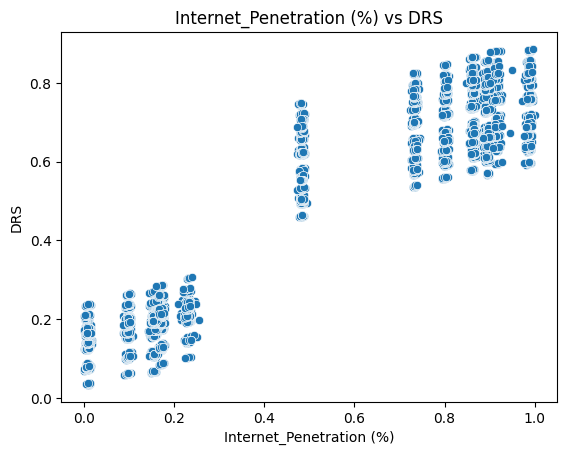

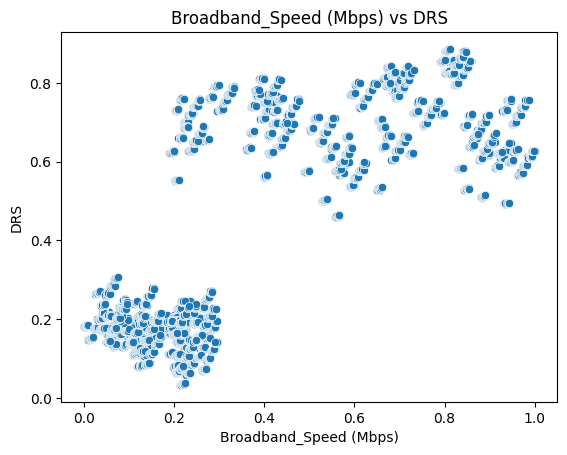

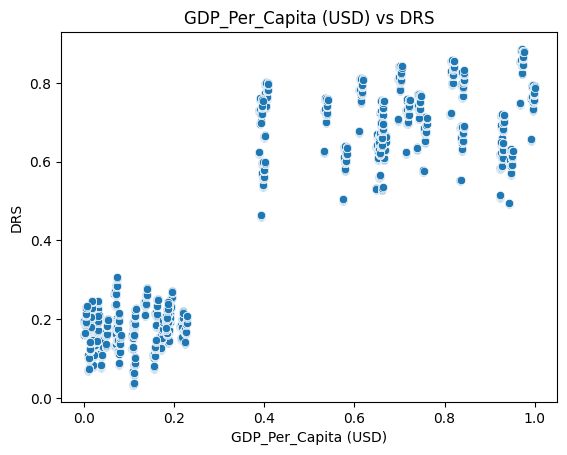

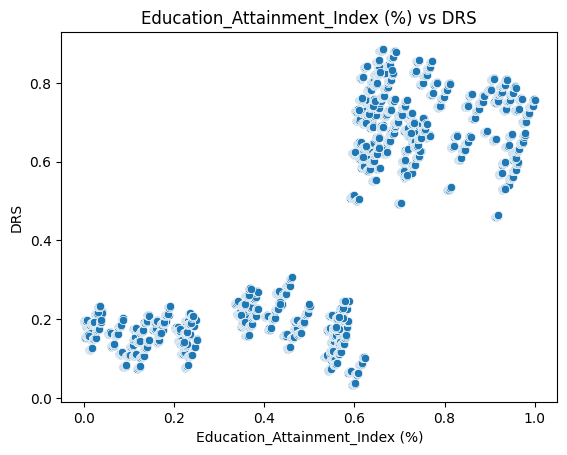

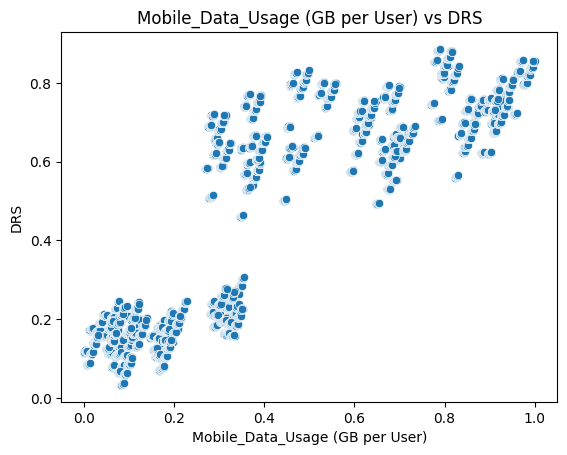

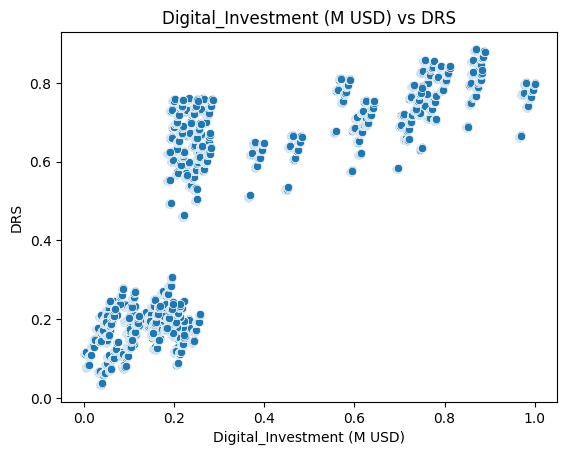

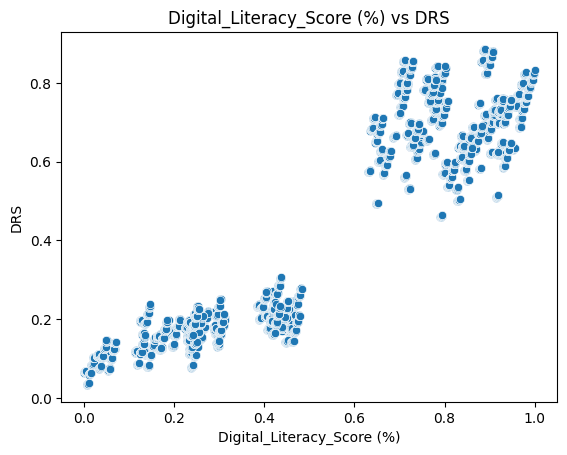

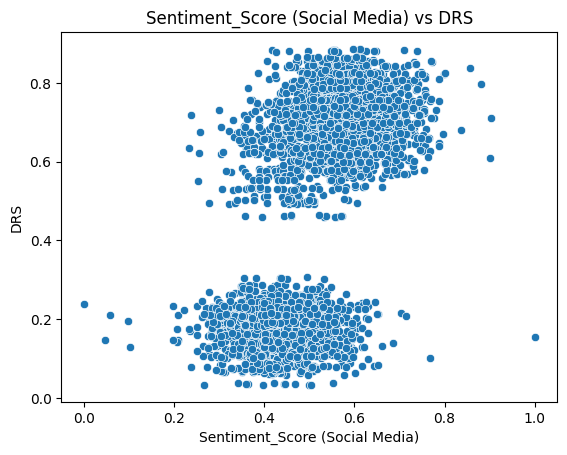

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature in features_to_scale:
    sns.scatterplot(x=df[feature], y=df['DRS'])
    plt.title(f"{feature} vs DRS")
    plt.show()


MODEL SELECTION

In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Step 5 – Model Selection & Evaluation

# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# To store model performance
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

# Convert results to DataFrame for clarity
results_df = pd.DataFrame(results)
print("\nModel Comparison Results:")
print(results_df)



Model Comparison Results:
                    Model  Accuracy  Precision    Recall  F1 Score
0           Random Forest  0.980000        1.0  0.928571  0.962963
1       Gradient Boosting  0.980000        1.0  0.928571  0.962963
2  Support Vector Machine  0.960000        1.0  0.857143  0.923077
3     K-Nearest Neighbors  0.965714        1.0  0.877551  0.934783


MODEL TRAINING

In [22]:
# Step 8 – Model Training
rf = RandomForestClassifier(
    n_estimators=150,          # uses 150 decision trees
    max_depth=8,               # ensures tree depth doesn’t exceed 8 (prevents overfitting)
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    oob_score=True
)
rf.fit(X_train, y_train)
print("✅ Random Forest model trained successfully!")


✅ Random Forest model trained successfully!


MODEL EVALUAION

In [23]:
# Step 9 – Model Evaluation
y_train_pred = rf.predict(X_train)
y_test_pred  = rf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print("\n📊 MODEL PERFORMANCE")
print("Training Accuracy :", round(train_acc * 100, 2), "%")
print("Testing Accuracy  :", round(test_acc * 100, 2), "%")
print("OOB Score         :", round(rf.oob_score_ * 100, 2), "%")

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))



📊 MODEL PERFORMANCE
Training Accuracy : 99.97 %
Testing Accuracy  : 98.0 %
OOB Score         : 99.8 %

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       252
           1       1.00      0.93      0.96        98

    accuracy                           0.98       350
   macro avg       0.99      0.96      0.97       350
weighted avg       0.98      0.98      0.98       350



In [24]:
# Step 10 – Cross-Validation
cv_scores = cross_val_score(rf, df[features_to_scale], df['Digitally_Ready'], cv=5)
print("\n🔁 CROSS-VALIDATION")
print("Mean Accuracy :", round(cv_scores.mean()*100, 2), "%")



🔁 CROSS-VALIDATION
Mean Accuracy : 86.97 %


FEATURE IMPORTANCE

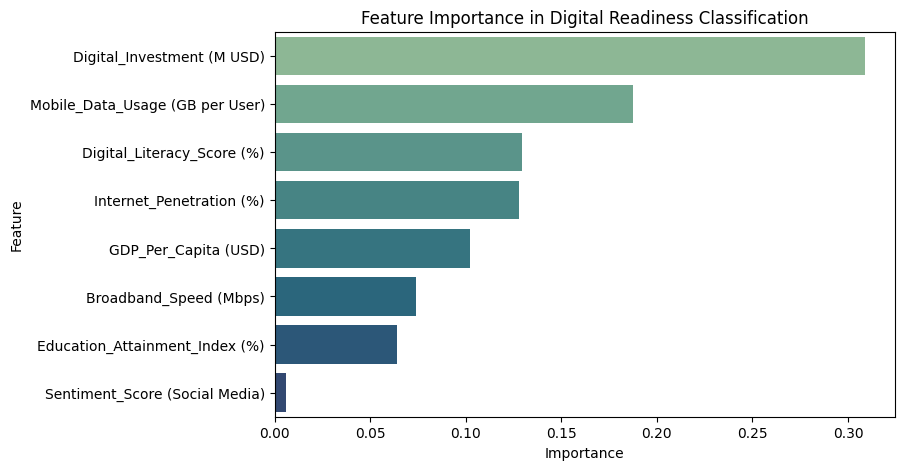

In [26]:
# Step 12 – Feature Importance Visualization
importances = rf.feature_importances_
feat_imp = pd.DataFrame({'Feature': features_to_scale, 'Importance': importances})
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='crest')
plt.title("Feature Importance in Digital Readiness Classification")
plt.show()
